# Connection to drive and path definition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/final/SANDS')
path_files ='/content/drive/MyDrive/Colab Notebooks/final/UC10'
path_config_files = '/content/drive/MyDrive/Colab Notebooks/final/UC10/configs'

# Import libraries

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error
import time
from calendar import timegm, monthrange
from datetime import datetime, timedelta
import math
import sands
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow import keras
from os import listdir
from os.path import isfile, join
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import CategoricalAccuracy,Accuracy,BinaryAccuracy


import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.api import ExponentialSmoothing
from scipy.stats import iqr


import json

import nltk
from nltk.tokenize import RegexpTokenizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.manifold import TSNE
from progressbar import ProgressBar
import h5py

import random
from tensorflow.keras.preprocessing.text import Tokenizer,tokenizer_from_json
import gc
from termcolor import colored






# Data generation or load

In [ ]:
configuration_template_file = 'config_template.txt'
configuration_start_point = '!'
test_samples = 10
context_before = 50
context_after = 50
max_dictionary_size = 50000
top_n_probabilities = 10
probability_threshold = 3
word_variability_threshold = 10
latent_len = 512
training_size = 100000
testing_size = 2000
total_subset = training_size+testing_size
batch_size = 1024
nb_epoch = 10
training_steps_per_epoch = np.ceil(training_size/batch_size)
validation_steps_per_epoch = np.ceil(testing_size/batch_size)
test_file = 'config_PE-100.cfg'
tokenizer_file = 'tokenizer-pe.json'
model_weights_file = 'weights_config_anomaly_PE_blstm.best.hdf5'

In [ ]:
device_filter = {
    'role': 'PE'
}

In [ ]:
configs_df = sands.generate_device_configs(join(path_files,configuration_template_file),"none",device_filter = device_filter)

In [ ]:
configs_df

,device_name,config
0,PE-1,!Image: Software version: IOS-XR 7.6R3\n!Image...
1,PE-2,!Image: Software version: IOS-XR 7.6R3\n!Image...
2,PE-3,!Image: Software version: IOS-XR 7.6R3\n!Image...
3,PE-4,!Image: Software version: IOS-XR 7.6R3\n!Image...
4,PE-5,!Image: Software version: IOS-XR 7.6R3\n!Image...
...,...,...
95,PE-96,!Image: Software version: IOS-XR 7.6R3\n!Image...
96,PE-97,!Image: Software version: IOS-XR 7.6R3\n!Image...
97,PE-98,!Image: Software version: IOS-XR 7.6R3\n!Image...
98,PE-99,!Image: Software version: IOS-XR 7.6R3\n!Image...


In [ ]:
for i,config_item in configs_df.iterrows():
  with open(join(path_config_files,'config_'+str(config_item['device_name'])+'.cfg'), 'w') as f:
    f.writelines(config_item['config'])

# Data pre-processing

In [ ]:
config_files = [f for f in listdir(path_config_files) if (isfile(join(path_config_files, f)))]

In [ ]:
config_files

['config_PE-1.cfg',
 'config_PE-2.cfg',
 'config_PE-3.cfg',
 'config_PE-4.cfg',
 'config_PE-5.cfg',
 'config_PE-6.cfg',
 'config_PE-7.cfg',
 'config_PE-8.cfg',
 'config_PE-9.cfg',
 'config_PE-10.cfg',
 'config_PE-11.cfg',
 'config_PE-12.cfg',
 'config_PE-13.cfg',
 'config_PE-14.cfg',
 'config_PE-15.cfg',
 'config_PE-16.cfg',
 'config_PE-17.cfg',
 'config_PE-18.cfg',
 'config_PE-19.cfg',
 'config_PE-20.cfg',
 'config_PE-21.cfg',
 'config_PE-22.cfg',
 'config_PE-23.cfg',
 'config_PE-24.cfg',
 'config_PE-25.cfg',
 'config_PE-26.cfg',
 'config_PE-27.cfg',
 'config_PE-28.cfg',
 'config_PE-29.cfg',
 'config_PE-30.cfg',
 'config_PE-31.cfg',
 'config_PE-32.cfg',
 'config_PE-33.cfg',
 'config_PE-34.cfg',
 'config_PE-35.cfg',
 'config_PE-36.cfg',
 'config_PE-37.cfg',
 'config_PE-38.cfg',
 'config_PE-39.cfg',
 'config_PE-40.cfg',
 'config_PE-41.cfg',
 'config_PE-42.cfg',
 'config_PE-43.cfg',
 'config_PE-44.cfg',
 'config_PE-45.cfg',
 'config_PE-46.cfg',
 'config_PE-47.cfg',
 'config_PE-48.cfg',
 

In [ ]:
def config_train_test_split(target_configs,test_samples):
  test_files_indexes = random.sample(range(len(target_configs)),test_samples)
  train_configs = []
  test_configs = []
  for i in range(len(target_configs)):
    if i in test_files_indexes:
      test_configs.append(target_configs[i])
    else:
      train_configs.append(target_configs[i])
  return train_configs,test_configs

In [ ]:
train_configs,test_configs=config_train_test_split(config_files,test_samples)

In [ ]:
def find_config_start(config_lines, start_sequence):
  i=0
  config_found = np.False_
  while not config_found:
    if start_sequence in config_lines[i]:
      config_found = True
      config_index = i+1
    else:
      i+=1
  return config_index

In [ ]:
def get_lines(config_file):
  file_handle = open(config_file, 'r')
  config_lines = file_handle.readlines() 
  return config_lines

In [ ]:
def get_config_lines(config_file):
  file_handle = open(config_file, 'r')
  config_lines = file_handle.readlines() 
  config_index = find_config_start(config_lines,configuration_start_point)
  return config_lines[config_index:]


In [ ]:
def build_corpus(train_configs,path):
  for config_file in train_configs:
    corpus = []
    print('Config:',config_file)
    config_lines = get_config_lines(join(path,config_file))
    for i in range(len(config_lines)):
      corpus += config_lines[i].lower().split()
    yield corpus

In [ ]:
def build_tokenizer(train_configs,path):
  tokenizer = Tokenizer(filters='',oov_token='OOV',num_words=max_dictionary_size)
  tokenizer.fit_on_texts(build_corpus(train_configs,path))
  total_words = len(tokenizer.word_index) + 1   
  print(total_words)
  return tokenizer

In [ ]:
tokenizer = build_tokenizer(train_configs,path_config_files)

Config: config_PE-1.cfg
Config: config_PE-2.cfg
Config: config_PE-3.cfg
Config: config_PE-4.cfg
Config: config_PE-5.cfg
Config: config_PE-6.cfg
Config: config_PE-7.cfg
Config: config_PE-8.cfg
Config: config_PE-9.cfg
Config: config_PE-10.cfg
Config: config_PE-11.cfg
Config: config_PE-12.cfg
Config: config_PE-13.cfg
Config: config_PE-14.cfg
Config: config_PE-15.cfg
Config: config_PE-17.cfg
Config: config_PE-18.cfg
Config: config_PE-20.cfg
Config: config_PE-21.cfg
Config: config_PE-23.cfg
Config: config_PE-24.cfg
Config: config_PE-25.cfg
Config: config_PE-27.cfg
Config: config_PE-28.cfg
Config: config_PE-29.cfg
Config: config_PE-30.cfg
Config: config_PE-31.cfg
Config: config_PE-32.cfg
Config: config_PE-33.cfg
Config: config_PE-34.cfg
Config: config_PE-35.cfg
Config: config_PE-36.cfg
Config: config_PE-37.cfg
Config: config_PE-38.cfg
Config: config_PE-39.cfg
Config: config_PE-40.cfg
Config: config_PE-41.cfg
Config: config_PE-42.cfg
Config: config_PE-43.cfg
Config: config_PE-44.cfg
Config: c

In [ ]:
tokenizer_json = tokenizer.to_json()
with open(join(path_files,tokenizer_file), 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
with open(join(path_files,tokenizer_file)) as f:
    data = json.load(f)
    tokenizer = tokenizer_from_json(data)

In [ ]:
total_words = len(tokenizer.word_index)+1
dictionary_size=min(total_words,max_dictionary_size)

In [ ]:
dictionary_size

1770

In [ ]:
def build_training_data(train_config, tokenizer):
  input_sequences = []
  input_labels = []
  current_index = 0
  corpus = []
  config_lines = get_config_lines(train_config)
  for i in range(len(config_lines)):
      corpus += config_lines[i].lower().split()
  while (current_index + context_before + context_after+1) < len(corpus):
    current_sequence = corpus[current_index:(current_index+context_before)]+corpus[(current_index+context_before+1):(current_index+context_before+context_after+1)]
    current_label = corpus[current_index+context_before]
    token_list = tokenizer.texts_to_sequences([current_sequence])[0]
    token_label = tokenizer.texts_to_sequences([current_label])[0]
    input_sequences.append(token_list)
    input_labels.append(token_label)
    current_index +=1
  xs, labels = np.array(input_sequences),np.array(input_labels)
  ys = tf.keras.utils.to_categorical(labels, num_classes=(dictionary_size))
  return xs,ys

In [ ]:
def build_training_data_batch(corpus, tokenizer, start_index, batch_size):
  input_sequences = []
  input_labels = []
  current_index = start_index
  config_finished=False
  for i in range(batch_size):
    if (current_index + context_before + context_after) < len(corpus):
      current_sequence = corpus[current_index:(current_index+context_before)]+corpus[(current_index+context_before+1):(current_index+context_before+context_after+1)]
      current_label = corpus[current_index+context_before]
      token_list = tokenizer.texts_to_sequences([current_sequence])[0]
      token_label = tokenizer.texts_to_sequences([current_label])[0]
      input_sequences.append(token_list)
      input_labels.append(token_label)
      current_index +=1
    else:
      config_finished = True
  xs, labels = np.array(input_sequences),np.array(input_labels)
  ys = tf.keras.utils.to_categorical(labels, num_classes=(dictionary_size))
  return xs,ys,config_finished

In [ ]:
def batch_generator(train_configs,path, batch_size, steps):
  xs = []
  ys = []
  i=0
  idx_total=1
  while True:
    config=train_configs[i]
    corpus = []
    config_lines=get_config_lines(join(path,config))
    for j in range(len(config_lines)):
      corpus += config_lines[j].lower().split()

    idx=1
    del xs
    del ys
    gc.collect()
    done_yet = False
    while not done_yet:
      start_index = (idx-1)*batch_size
      xs,ys,done_yet = build_training_data_batch(corpus,tokenizer,start_index,batch_size)
      stop_index = start_index + batch_size
      X_batch = xs
      y_batch = ys
      yield (X_batch,y_batch)
      if not done_yet:
        if idx_total < steps:
            idx +=1
            idx_total +=1
        else:
            idx_total=1
            done_yet=True
      else:
        if idx < steps:
            idx +=1
            if i<(len(train_configs)-1):
              i+=1
            else:
              i=0
        else:
            idx_total=1
            i=0

In [ ]:
total_words = len(tokenizer.word_index)+1
total_next_words = []
for w in range(total_words):
  total_next_words.append([])
total_nexts = [0 for i in range(total_words)]
pbar = ProgressBar()
for config in pbar(train_configs):
  corpus = []
  config_lines = get_config_lines(join(path_config_files,config))
  for i in range(len(config_lines)):
    corpus += config_lines[i].lower().split()
  for i in range(len(corpus)-1):
    current_token = tokenizer.texts_to_sequences([corpus[i]])[0][0]
    next_token = tokenizer.texts_to_sequences([corpus[i+1]])[0][0]
    current_token_nexts = total_next_words[current_token]
    if next_token not in current_token_nexts:
      total_next_words[current_token].append(next_token)
      total_nexts[current_token]+=1

100% (90 of 90) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [ ]:
my_training_batch_generator = batch_generator(train_configs,path_config_files,batch_size,training_steps_per_epoch)

# Model definition and training

In [ ]:
mymodel = tf.keras.Sequential()
mymodel.add(Embedding(dictionary_size, 100, input_length=(context_before+context_after)))
mymodel.add(Bidirectional(LSTM(128,recurrent_dropout=0.1)))
mymodel.add(Dense(dictionary_size,activation='softmax'))
mymodel.add(layers.Dropout(0.1))

In [ ]:
mymodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          177000    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1770)              454890    
                                                                 
 dropout (Dropout)           (None, 1770)              0         
                                                                 
Total params: 866,386
Trainable params: 866,386
Non-trainable params: 0
_________________________________________________________________


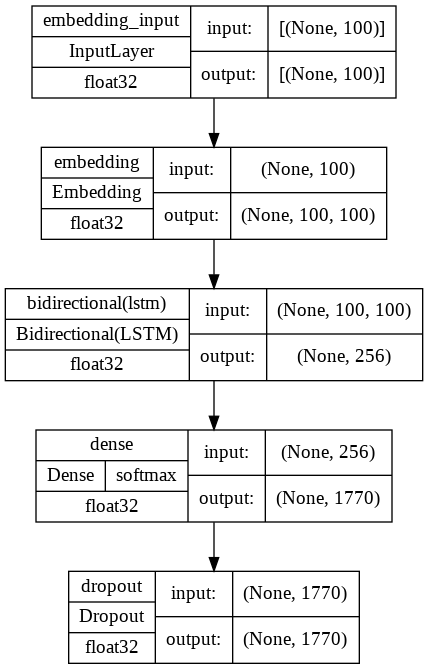

In [ ]:
tf.keras.utils.plot_model(mymodel,show_shapes=True,show_dtype=True,show_layer_names=True,show_layer_activations=True)

In [ ]:
adam = Adam(lr=0.01)
mymodel.compile(optimizer=adam, loss='categorical_crossentropy',metrics=['accuracy'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
mymodel.load_weights(join(path_files,model_weights_file))

In [ ]:
filepath=join(path_files,model_weights_file)
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [ ]:
history = mymodel.fit_generator(my_training_batch_generator,epochs=nb_epoch,steps_per_epoch=training_steps_per_epoch, verbose=1,callbacks=callbacks_list, use_multiprocessing=False)

<ipython-input-34-569b2839e621>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = mymodel.fit_generator(my_training_batch_generator,epochs=nb_epoch,steps_per_epoch=training_steps_per_epoch, verbose=1,callbacks=callbacks_list, use_multiprocessing=False)


Epoch 1/10
98/98 [==============================] - ETA: 0s - loss: 3.6167 - accuracy: 0.5361
Epoch 1: loss improved from inf to 3.61670, saving model to /content/drive/MyDrive/Colab Notebooks/final/UC10/weights_config_anomaly_PE_blstm.best.hdf5
98/98 [==============================] - 102s 982ms/step - loss: 3.6167 - accuracy: 0.5361
Epoch 2/10
98/98 [==============================] - ETA: 0s - loss: 1.9018 - accuracy: 0.8621
Epoch 2: loss improved from 3.61670 to 1.90175, saving model to /content/drive/MyDrive/Colab Notebooks/final/UC10/weights_config_anomaly_PE_blstm.best.hdf5
98/98 [==============================] - 94s 960ms/step - loss: 1.9018 - accuracy: 0.8621
Epoch 3/10
98/98 [==============================] - ETA: 0s - loss: 1.8521 - accuracy: 0.8648
Epoch 3: loss improved from 1.90175 to 1.85212, saving model to /content/drive/MyDrive/Colab Notebooks/final/UC10/weights_config_anomaly_PE_blstm.best.hdf5
98/98 [==============================] - 97s 989ms/step - loss: 1.8521 - 

# Model evaluation

In [ ]:
def predict_config_accuracy(config_file, model, tokenizer):
  xs,ys = build_training_data(config_file, tokenizer)
  score, acc = model.evaluate(xs[0:2000], ys[0:2000])
  return score, acc

In [ ]:
def predict_config(config_file, model, tokenizer):
  xs,ys = build_training_data(config_file, tokenizer)
  y_pred = model(xs[0:1000])
  return y_pred

In [ ]:
def convert_to_text(y_pred, tokenizer):
  predicted_words_index = [int(np.argmax(y_pred[i,:])) for i in range(y_pred.shape[0])]
  predicted_words = tokenizer.sequences_to_texts([predicted_words_index])[0]
  return predicted_words

In [ ]:
score, acc = predict_config_accuracy(join(path_config_files,test_file),mymodel,tokenizer)

19/19 [==============================] - 1s 54ms/step - loss: 0.1604 - accuracy: 0.9732


In [ ]:
def compute_config_anomaly_vector(config_file, model, tokenizer):
  xs,ys = build_training_data(config_file, tokenizer)
  #predicted_prob = model.predict_proba(xs, verbose=0)
  y_pred = model(xs).numpy()
  real_words_index = [int(np.argmax(ys[i,:])) for i in range(ys.shape[0])]
  y_probability = []
  y_recommended = []
  for i in range(1,y_pred.shape[0]):
    temp = np.partition(-y_pred[i,:], top_n_probabilities)
    y_pred_average=np.mean(-temp[:top_n_probabilities])
    y_pred_prob = y_pred[i,real_words_index[i]]
    y_recom = np.argmax(y_pred[i,:])
    word_variability = total_nexts[real_words_index[i-1]]
    if word_variability > word_variability_threshold:
      probability = top_n_probabilities
    else:
      probability = y_pred_prob/y_pred_average
    y_probability.append(probability)
    y_recommended.append(y_recom)
  return y_probability,y_recommended  

In [ ]:
y_probability,_ = compute_config_anomaly_vector(join(path_config_files,test_file),mymodel,tokenizer)

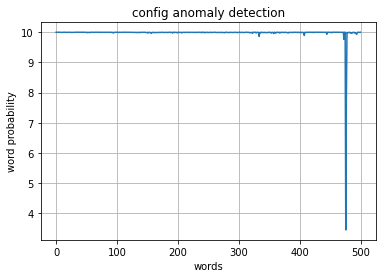

In [ ]:
fig, ax = plt.subplots()
ax.plot(y_probability[0:500])

ax.set(xlabel='words', ylabel='word probability',
       title='config anomaly detection')
ax.grid()
plt.show()

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.,   1., 591.]),
 array([ 3.45481801,  3.67299074,  3.89116348,  4.10933621,  4.32750894,
         4.54568168,  4.76385441,  4.98202714,  5.20019987,  5.41837261,
         5.63654534,  5.85471807,  6.07289081,  6.29106354,  6.50923627,
         6.72740901,  6.94558174,  7.16375447,  7.3819272 ,  7.60009994,
         7.81827267,  8.0364454 ,  8.25461814,  8.47279087,  8.6909636 ,
         8.90913634,  9.12730907,  9.3454818 ,  9.56365453,  9.78182727,
        10.        ]),
 <a list of 30 Patch objects>)

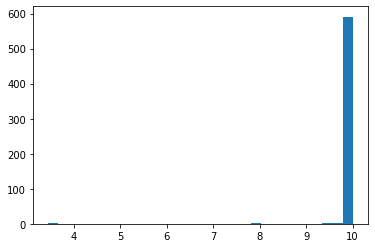

In [ ]:
fig, ax = plt.subplots()
ax.hist(y_probability, bins=30)

In [ ]:
def display_config_anomalies(config_file,model,tokenizer):
  y_probability,y_recommended = compute_config_anomaly_vector(config_file,model,tokenizer)
  config_lines = get_config_lines(config_file)
  corpus = []
  for i in range(len(config_lines)):
      corpus += config_lines[i].lower().split()
  y_words = corpus[context_before+1:-(context_after+1)]
  probability_mask = np.array(y_probability) > probability_threshold
  print('Number of anomalies detected:',(len(y_words)-np.sum(probability_mask)))
  colored_config = ''
  word_index = 0 
  for w in range(len(config_lines)):
    tokenized_line = config_lines[w].split()
    for item in tokenized_line:
      if word_index>=(context_before+1) and word_index<(len(corpus)-(context_after+1)):
        if probability_mask[word_index-(context_before+1)]:
          colored_config += '\033[92m '+item
        else:
          colored_config += '\033[91m '+item + '(expected: '+tokenizer.sequences_to_texts([[y_recommended[word_index-(context_before+1)]]])[0]+')'
      else:
          colored_config += '\033[94m '+item
      word_index+=1
    colored_config += '\n'

  print(colored_config)                  
  return y_words

# Configuration anomalies detection

In [ ]:
y_words = display_config_anomalies(join(path_config_files,test_file),mymodel,tokenizer)

Number of anomalies detected: 6
 !Image: Copyright (C) 2020 your favorite vendor. All rights reserved
 !Image: Software Product: IOS-XR, Version: 7.6R3
 !Image: Hardware Model: ASR
 !Image: Software Feature Code: SP
 !Image: System Configuration Code: S3
 !Image: Package Configuration Code: P4
 !Image: Software Baseline Version: 2.3.5
 !Image: Installation Information:
 !Image: Image Filename: IOS-XR-7-6-R-3
 !Image: ONIE SysInfo: x86_64-accton_asr7736_64x-r0
 !
 !
 !
 !
 !
 !
 ! Software version: IOS-XR 6.5R4(expected: 7.6r3)
 !
 !
 logging level cml 5
 !
 service password-encryption
 !
 enable confirmation-dialog
 !
 no logging console
 no logging monitor
 logging level nsm 5
 logging level rip 5
 logging level ripng 5
 logging level ospf 5
 logging level ospf6 5
 logging level isis 5
 logging level hostp 5
 logging level mrib 5
 logging level pim 5
 logging level auth 5
 logging level mstp 5
 logging level onm 5
 logging level hsl 5
 logging level oam 5
 logging level vlog 5
 loggin